<a href="https://colab.research.google.com/github/fclubb/EarthSurfaceProcesses/blob/master/Week6_ErosionRates/Part2_plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 2: plotting erosion rates and doing extra topographic analysis



*This lesson has been written Fiona Clubb at Durham University*

In the first part of the practical we downloaded a DEM, some erosion rate data, and basin shapefiles for the Southern Alps of New Zealand using the OCTOPUS database. Now we're going to read these data into python and make some plots.

This notebook shows you how to:

* Read a DEM and a shapefile into Python
* Plot erosion rate vs. mean basin slope
* Do a channel steepness analysis (see Week 3) and plot erosion rate vs. mean channel steepness.

We will do the channel steepness analysis using **lsdtopotools**. **lsdtopotools** is a software package for analysing topography developed at the University of Edinburgh, Durham University, and other institutions. 

-------------------------
### BEFORE YOU BEGIN
Remember to copy this notebook to your Google Drive using the "Copy to Drive" button 

## Upload your DEM and erosion rate data

We need to upload the data that we downloaded from OCTOPUS to Google Colaboratory. To do this, click on the small folder icon on the left hand bar and then click `Upload to Session Storage`. Navigate to the DEM that we downloaded (in the Raster folder) and upload the two files: ``s147_demhydro.bil`` and ``s147_demhydro.hdr``. You also need to upload the shapefile that we created in ArcGIS/QGIS, which has the mean basin slope and erosion rate data for each basin. Shapefiles tend to be made up of 4-5 files which have different file extensions but the same filename (which you chose in the GIS program). You need to upload ALL the files that were created. For my example, I would upload all the files called ``Basins_slope``:
  * Basins_slope.dbf
  * Basins_slope.prj
  * Basins_slope.shp
  * Basins_slope.shx

  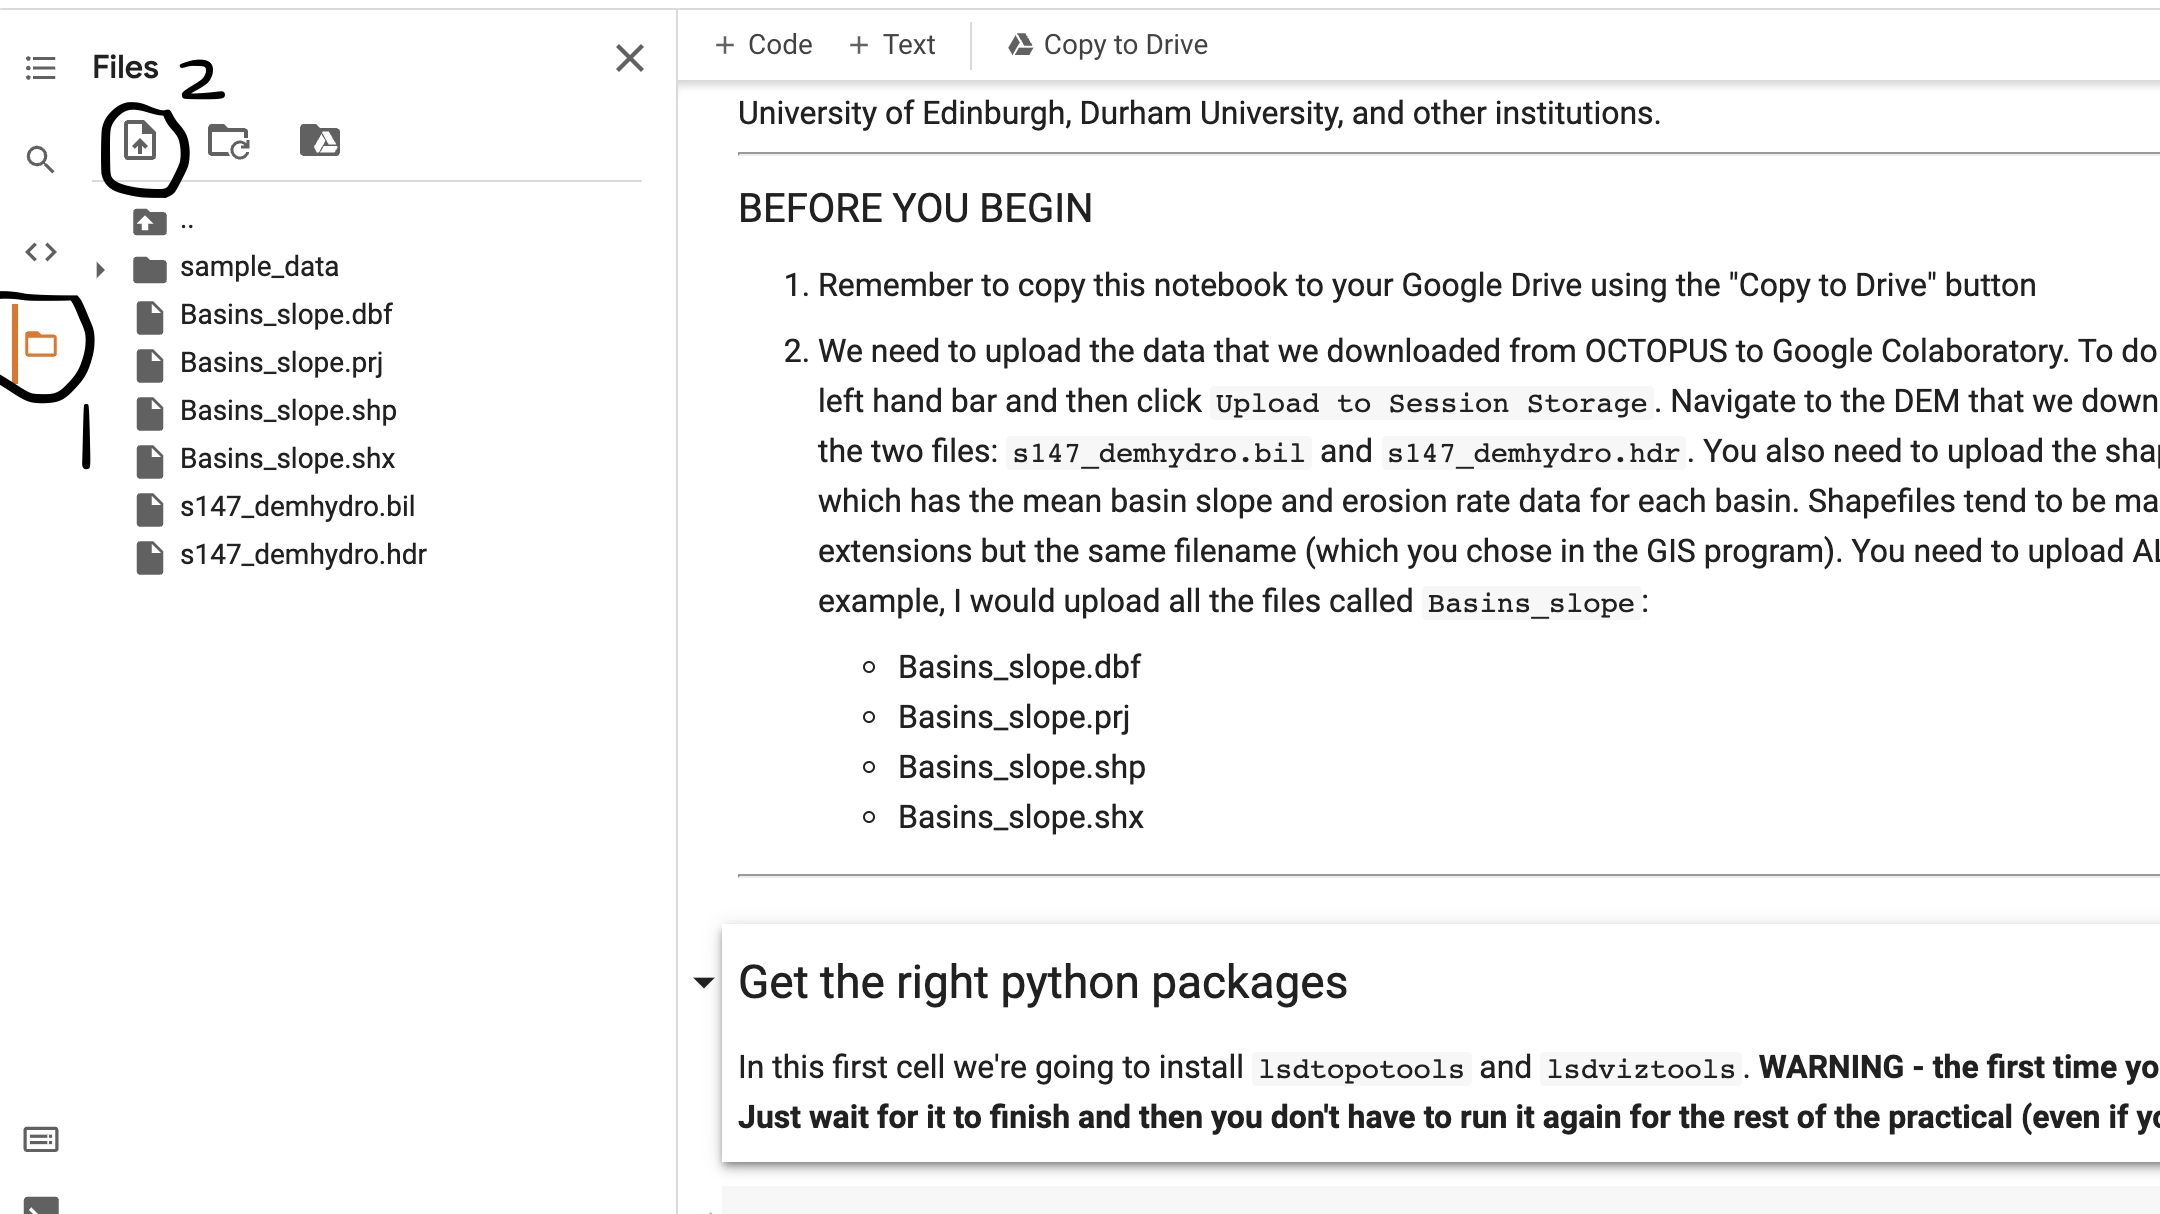

-------------------------


## Get the right python packages

In this first cell we're going to install `lsdtopotools` and `lsdviztools`. 
**WARNING - the first time you do this, it might take up to 5 minutes. Just wait for it to finish and then you don't have to run it again for the rest of the practical (even if you need to restart the kernel).**



In [31]:
!pip install lsdviztools &> /dev/null


First we download miniconda, which takes about 30 seconds.

In [32]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-py37_4.8.2-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.anaconda.com/miniconda/$MINICONDA_INSTALLER_SCRIPT &> /dev/null
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX &> /dev/null


The next step is to set the conda channels, install mamba (because it installs lsdtopotools much faster than conda) and then finally lsdtopotools. This takes ~3.5 minutes.

In [33]:
!conda config --add channels conda-forge &> /dev/null
!conda config --set channel_priority strict &> /dev/null
!conda install -c conda-forge -y mamba &> /dev/null
!mamba install -c conda-forge -y lsdtopotools &> /dev/null

In [13]:
!apt install gdal-bin python-gdal python3-gdal &> /dev/null
# Install rtree - Geopandas requirment
!apt install python3-rtree &> /dev/null
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git &> /dev/null
# Install descartes - Geopandas requirment
!pip install descartes 

In [14]:
#lsdtopotools
import lsdviztools.lsdbasemaptools as bmt
from lsdviztools.lsdplottingtools import lsdmap_gdalio as gio
import lsdviztools.lsdmapwrappers as lsdmw

#pandas
import pandas as pd
import geopandas as gpd

#colab
from google.colab import files

# statistics
from scipy import stats

#general
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
%matplotlib inline

## Read in the basin shapefile


First, let's read in the basin shapefile. To do this we will use a package called ``geopandas``: this is a python package specifically designed for reading in geographic data (e.g. polygons) and analysing it. You can find more information here: https://geopandas.org/getting_started/introduction.html

In the block below, you will need to change the `shapefile_name` variable to be the name of the shapefile that you uploaded in the previous step.

In [15]:
# Read in the shapefile to a geopandas dataframe
shapefile_name = 'Basins_slope.shp'
gdf = gpd.read_file(shapefile_name)

Now we have a variable `gdf` which has the data that was in the shapefile in it (this is the same as the Attribute table that you can open in QGIS/ArcGIS. Let's look at it:

In [48]:
gdf

,SMPID1,SMPID2,IGSNID,STUDYID,AUTH,PUBYEAR,REFID,REFDOI,DBDOI,DBVER,BASIN,AHGFL1,AHGFL2,REGION,CNTRY,X_WGS84,Y_WGS84,MATERIAL,SIZEMIN,SIZEMAX,BE10NP,BE10NP_ERR,BE10EP,BE10EP_ERR,BESTND,BECORR,BEAMS,BE10NC,BE10NC_ERR,AL26NP,AL26NP_ERR,AL26EP,AL26EP_ERR,ALSTND,ALCORR,ALAMS,AL26NC,AL26NC_ERR,BEPROD,BETOPO,BESELF,BESNOW,BETOTS,EBE_GCMYR,ERRBE_AMS,ERRBE_MUON,ERRBE_PROD,ERRBE_TOT,EBE_MMKYR,EBE_ERR,ALPROD,ALTOPO,ALSELF,ALSNOW,ALTOTS,EAL_GCMYR,ERRAL_AMS,ERRAL_MUON,ERRAL_PROD,ERRAL_TOT,EAL_MMKYR,EAL_ERR,PROJECTION,AREA,ELEV_AVE,ELEV_STD,SLP_AVE,SLP_STD,_mean,_stdev,geometry
0,S147WTS006,Hokitika-sed,NA,S147,Larsen,2014.0,Science_343,10.1126/science.1244908,NA,2017.0,Hokitika Riv.,NA,NA,"West Coast, Soutern Island",NZL,170.995832,-42.988324,1.0,250.0,850.0,760.0,120.0,11650.0,2040.0,07KNSTD,1.0,LLNL-CAMS,760.0,120.0,-9999.0,-9999.0,-9999.99,-9999.99,NA,-9.9999,NA,-9999.0,-9999.0,2.748444,0.952688,1.0,1.0,2.621329,2.604608,0.421811,0.175639,0.483046,0.664911,9828.7095,2509.09860,-99.999,-9.999,-9.999,-9.999,-99.999,-9.99999,-9.99999,-9.99999,-9.99999,-9.99999,-9999.99,-9999.99,WGS84_UTM_59S,342.527936,1153.155570,463.747854,561.788578,213.443178,28.481991,9.214047,"POLYGON ((19030855.464 -5346727.682, 19030484...."
1,S147WTS004,Whataroa-sed,NA,S147,Larsen,2014.0,Science_343,10.1126/science.1244908,NA,2017.0,Whataroa Riv.,NA,NA,"West Coast, Soutern Island",NZL,170.413280,-43.293323,1.0,250.0,850.0,1260.0,330.0,6600.0,1910.0,07KNSTD,1.0,LLNL-CAMS,1260.0,330.0,-9999.0,-9999.0,-9999.99,-9999.99,NA,-9.9999,NA,-9999.0,-9999.0,2.952554,0.946737,1.0,1.0,2.791625,1.664196,0.468031,0.106524,0.307669,0.570140,6279.9863,2151.47340,-99.999,-9.999,-9.999,-9.999,-99.999,-9.99999,-9.99999,-9.99999,-9.99999,-9.99999,-9999.99,-9999.99,WGS84_UTM_59S,448.659020,1216.652372,543.844869,568.686108,264.324552,28.352878,11.110621,"POLYGON ((18964713.133 -5389604.283, 18964434...."
2,S147WTS005,Rapid-Creek-sed,NA,S147,Larsen,2014.0,Science_343,10.1126/science.1244908,NA,2017.0,Rapid Crk.,NA,NA,"West Coast, Soutern Island",NZL,171.011703,-43.014980,1.0,250.0,850.0,1640.0,150.0,5190.0,590.0,07KNSTD,1.0,LLNL-CAMS,1640.0,150.0,-9999.0,-9999.0,-9999.99,-9999.99,NA,-9.9999,NA,-9999.0,-9999.0,2.439782,0.951270,1.0,1.0,2.322615,1.081096,0.099741,0.080342,0.201833,0.239039,4079.6088,902.03267,-99.999,-9.999,-9.999,-9.999,-99.999,-9.99999,-9.99999,-9.99999,-9.99999,-9.99999,-9999.99,-9999.99,WGS84_UTM_59S,12.898106,1038.272727,339.570465,574.403595,192.893582,29.210199,8.316206,"POLYGON ((19032710.789 -5319521.984, 19032525...."
3,S147WTS007,Gunn-Ridge-sed,NA,S147,Larsen,2014.0,Science_343,10.1126/science.1244908,NA,2017.0,Whataroa Riv.,NA,NA,"West Coast, Soutern Island",NZL,170.401671,-43.396643,1.0,250.0,850.0,870.0,200.0,9020.0,2260.0,07KNSTD,2.0,LLNL-CAMS,1740.0,400.0,-9999.0,-9999.0,-9999.99,-9999.99,NA,-9.9999,NA,-9999.0,-9999.0,2.708340,0.944665,1.0,1.0,2.566044,1.115763,0.270873,0.076852,0.207244,0.349612,4210.4276,1319.28950,-99.999,-9.999,-9.999,-9.999,-99.999,-9.99999,-9.99999,-9.99999,-9.99999,-9.99999,-9999.99,-9999.99,WGS84_UTM_59S,0.693319,1175.759036,173.024867,663.981489,134.066838,33.257427,5.737626,"POLYGON ((18968794.848 -5372991.634, 18968609...."
4,S147WTS003,Docherty-Creek-sed,NA,S147,Larsen,2014.0,Science_343,10.1126/science.1244908,NA,2017.0,Docherty Crk.,NA,NA,"West Coast, Soutern Island",NZL,170.130825,-43.380008,1.0,250.0,850.0,2840.0,180.0,2190.0,190.0,07KNSTD,1.0,LLNL-CAMS,2840.0,180.0,-9999.0,-9999.0,-9999.99,-9999.99,NA,-9.9999,NA,-9999.0,-9999.0,1.611602,0.972533,1.0,1.0,1.559623,0.438161,0.027906,0.044074,0.083861,0.098762,1653.4389,372.68822,-99.999,-9.999,-9.999,-9.999,-99.999,-9.99999,-9.99999,-9.99999,-9.99999,-9.99999,-9999.99,-9999.99,WGS84_UTM_59S,28.470571,515.886932,373.773274,372.227009,266.043871,19.297288,12.809176,"POLYGON ((18940964.975 -5381038.663, 18940779...."
5,S147WTS002,Fox-sed,NA,S147,Larsen,2014.0,Science_343,10.1126/science.1244908,NA,2017.0,Fox Riv.,NA,NA,"West Coast, Soutern Island",NZL,169.996647,-43.479169,1.0,2

This should be familiar to you from the first step of the practical: it's the same data. You might notice that the very last column of this table is called `geometry`: this is how geopandas stores the geographic information. It stores a string of coordinates which gives you the outline of the basin polygon. We can use geopandas to very quickly and easily plot the shapefiles:

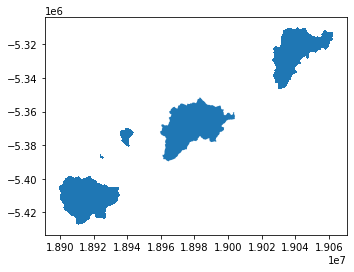

In [37]:
gdf.plot()

There you go - you can see the same basins that we could see in QGIS/ArcGIS!

## Making plots of erosion rate vs mean basin slope

In the first part of the practical, you were asked to qualitatively look at the distribution of erosion rates and mean basin slopes across the landscape. But what if we want to quantify this? To do that, we could make a scatter plot of erosion rate and mean basin slope, and then try to fit some kind of model through the data (e.g. a linear regression). First of all, let's just make a simple scatter plot. To do this we will use the python package `matplotlib`, which is a powerful package for making nice graphics. In the first step we imported it using the shorthand `plt`, so I'm just going to call `plt` here.

Text(0, 0.5, 'Catchment-averaged\n erosion rate (mm/kyr)')

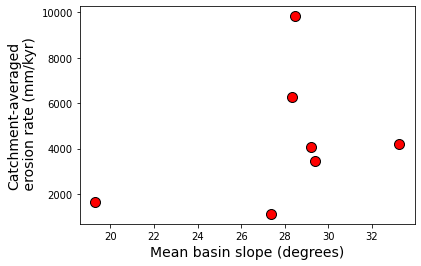

In [38]:
# make a scatter plot using matplotlib. The first parameter in the brackets is the X data, and the second is the Y data. 
# You can change the column names from the geopandas table to choose what you want to plot.
# Here I am plotting erosion rate (EBE_MMKYR) and the mean basin slope that we calculated (_mean).
# You can change the fill colour of the marker using 'color', the edge color using 'edgecolors', and the size using 's'
plt.scatter(gdf['_mean'], gdf['EBE_MMKYR'], color = 'red', edgecolors='black', s=100)
plt.xlabel('Mean basin slope (degrees)', fontsize=14)
plt.ylabel('Catchment-averaged\n erosion rate (mm/kyr)', fontsize=14)

Although we don't have a huge number of data points, you should be able to see that there isn't a great relationship between erosion rate and mean basin slope. Let's use python to fit a linear regression through these data and check the goodness of fit. To do that we will use the `stats` function from the `scipy` package:

In [39]:
# set the X and Y data for the linear regression
x = gdf['_mean']
y = gdf['EBE_MMKYR']

# do the linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# print out the equation of the line. We will round to 2 decimal places
print ('y = {}x + {}'.format(round(slope,2), round(intercept,2)))

# print out the R^2 value and the p value
print ('R^2: ', r_value**2)
print ('p value: ', p_value)

y = 246.86x + -2514.95
R^2:  0.1251519553197074
p value:  0.43628958918747024




---


## Exercise 1

* Think about what these statistics are telling you. Can these data be explained well with a linear regression model?

* Look at Figure 2 of Binnie et al. (2007):
Steven A. Binnie, William M. Phillips, Michael A. Summerfield, L. Keith Fifield; Tectonic uplift, threshold hillslopes, and denudation rates in a developing mountain range. _Geology_ 2007; 35 (8): 743–746. doi: https://doi.org/10.1130/G23641A.1

  
* How does your data compare to their plot? Does it look similar?

* Write a few sentences to explain why we might expect mean basin slope to be limited at high erosion rates.
---




## Channel steepness

So if mean basin slope is not a great predictor of erosion rates, what about channel steepness? From previous lectures we learnt that channel steepness (often referred to as $k_{sn}$) is often correlated with uplift rates in mountain landscapes. Let's calculate channel steepness for our DEM using the same technique we used in Week 3, and compare to the erosion rates.

Last time we downloaded a DEM directly in Python, but this time we don't need to do that as we already have the DEM uploaded into Colab (hooray)! So we just need to set the name of the DEM here and then run the code.

In [40]:
# SET THE NAME OF YOUR DEM HERE
DEM_name = 's147_demhydro'

command_line_tool = "lsdtt-chi-mapping"
lsdtt_parameters = {"print_segmented_M_chi_map_to_csv" : "true", 
                    "print_basin_raster" : "true",
                    "convert_csv_to_geojson" : "true"}

lsdtt_drive = lsdmw.lsdtt_driver(command_line_tool,read_prefix = DEM_name,
                                 write_prefix= DEM_name,
                                 read_path = "./",
                                 write_path = "./",
                                 parameter_dictionary=lsdtt_parameters)
lsdtt_drive.print_parameters()
lsdtt_drive.run_lsdtt_command_line_tool()

The lsdtopotools command line tools available are: 
['lsdtt-basic-metrics', 'lsdtt-channel-extraction', 'lsdtt-chi-mapping', 'lsdtt-cosmo-tool', 'lsdtt-hillslope-channel-coupling']
Please note only lsdtt-basic-metrics has been fully tested
The command line tool is: lsdtt-chi-mapping
The driver name is: Test_01
The read path is: ./
The write path is: ./
The read prefix is: s147_demhydro
The write prefix is: s147_demhydro
The parameter dictionary is:
{'print_segmented_M_chi_map_to_csv': 'true', 'print_basin_raster': 'true', 'convert_csv_to_geojson': 'true'}
Done writing the driver file
I've finised writing the driver file. Let me run LSDTT for you.


This has made some additional files which have the information about the channel steepness across the landscape. You can download the file `s147_demhydro_MChiSegmented.geojson` and load it into ArcGIS/QGIS to see the results. Mine looks like this:
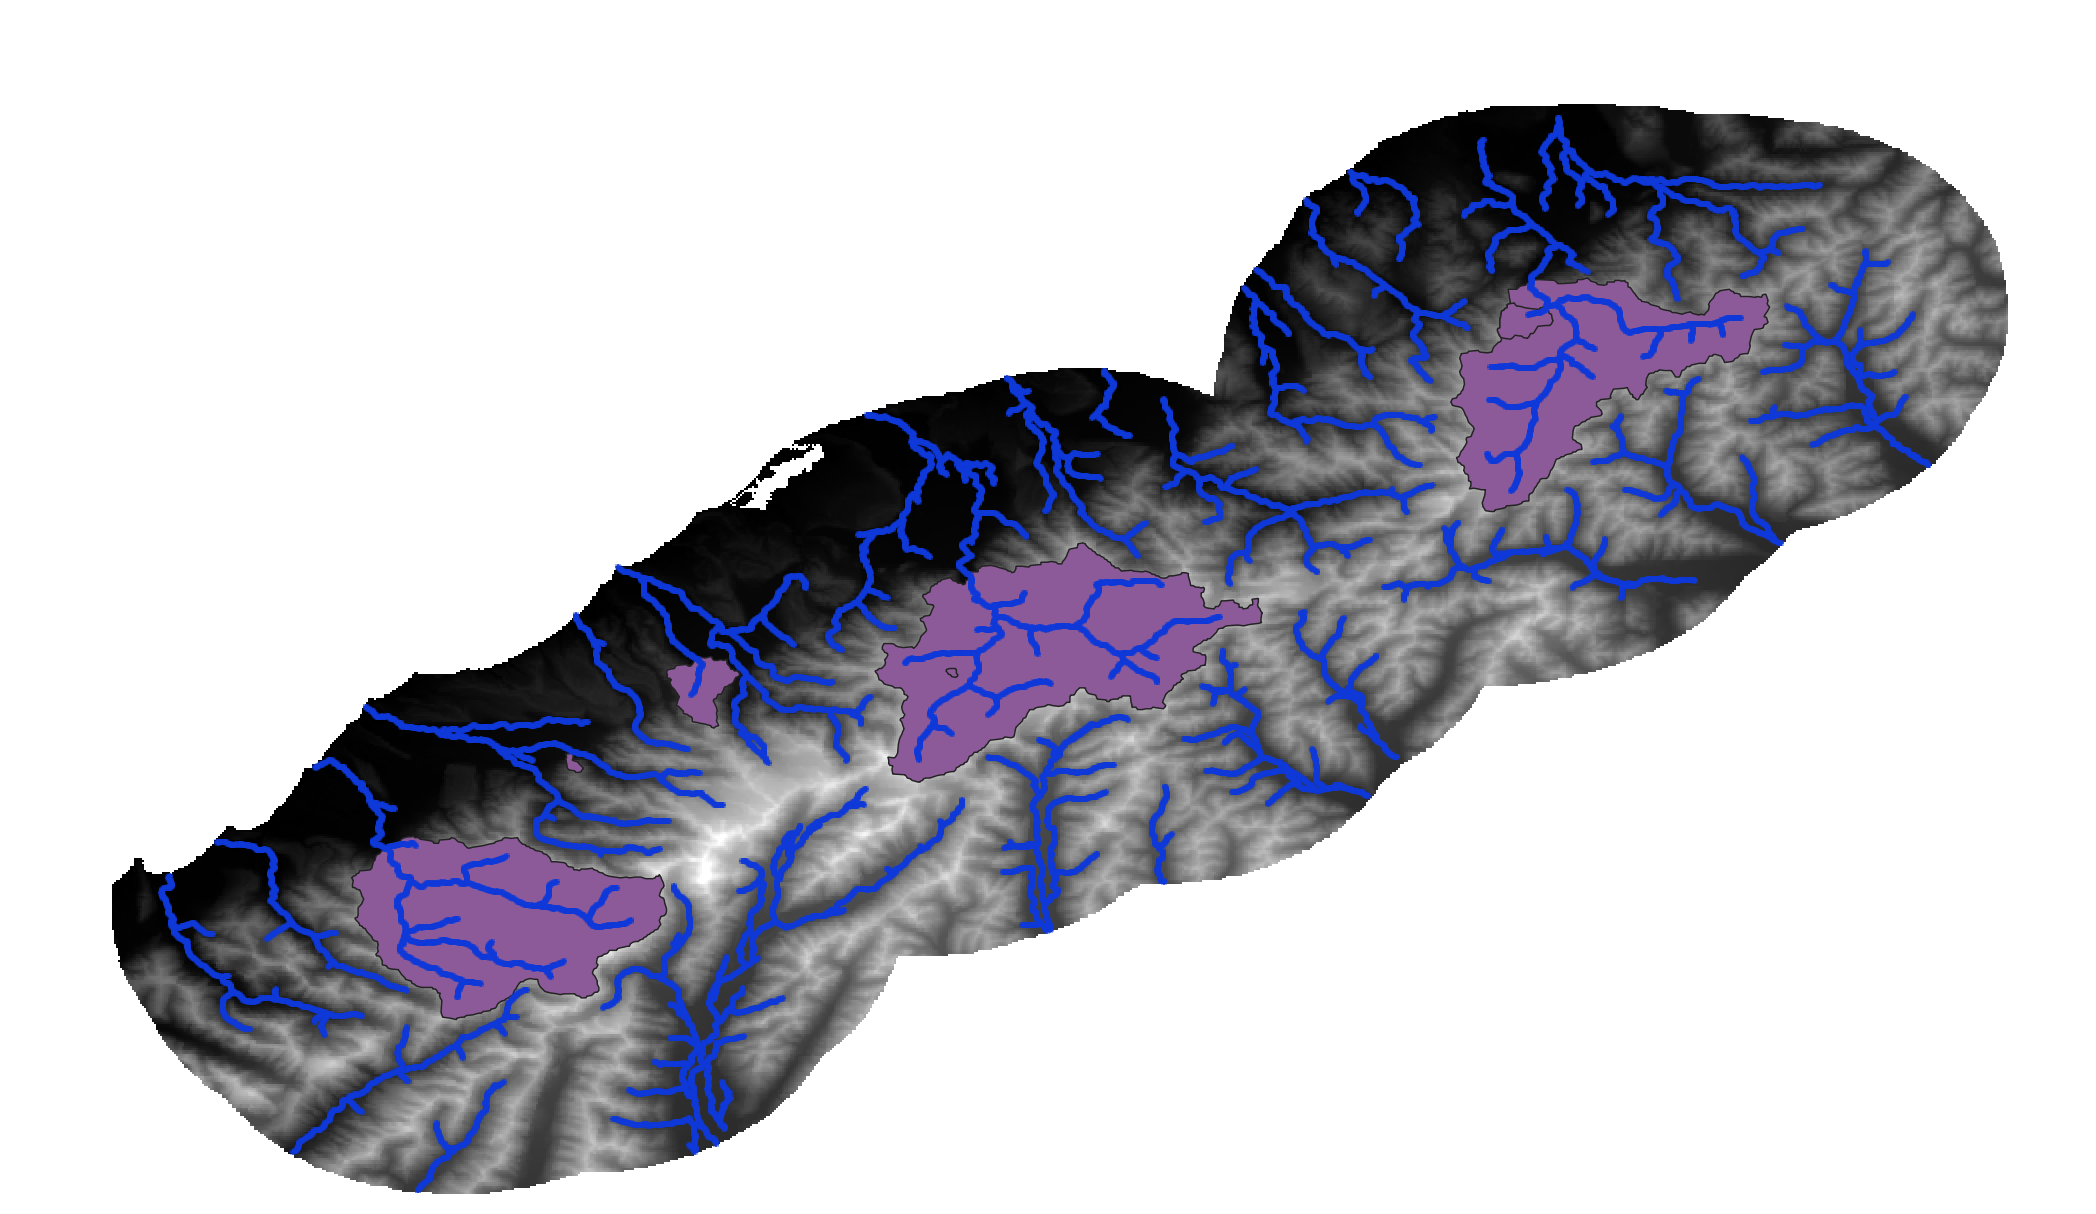



---


## Exercise 2

* Download the file `s147_demhydro_MChiSegmented.geojson` and load into QGIS/ArcGIS. Make a plot of the channel network coloured by channel steepness (the m_chi column) across the landscape. 

---



## Getting the mean channel steepness for each basin

Now we've got channel steepness for our landscape, we can find the mean values of channel steepness for each of the basins with erosion rate data. `geopanads` makes this easy to do, because we can simply look for each point on the river dataset that is within each basin polygon. That's what the code below does. First of all we will load in our channel steepness data to a second dataframe, and then merge it with the basins.

In [16]:
# Load in the channel steepness data to a geopandas geodataframe
channel_gdf = gpd.read_file('s147_demhydro_MChiSegmented.geojson')

# convert this to the same coordinate system as the erosion rate data
target_crs = gdf.crs
channel_gdf = channel_gdf.to_crs(target_crs)

# Use a spatial join to merge the channel steepness data with the erosion rate data
gdf = gpd.sjoin(gdf, channel_gdf, how='left')

ImportError: ignored

We can use the following command to see what columns we have in our data table:

In [ ]:
gdf.columns

Let's use this dataframe to plot a river profile! You should have seen from looking at the basins in QGIS that we have lots of different basins. If you look at the raster in QGIS, you can see that they are assigned a number which is a bit random. You should have chosen one of these numbers in Exercise 2. To make it more logical, each basin is also assigned a "basin_key" which starts at 0 and goes up. You can see the basin key information in the file `San_Gabriel_SRTMGL1_UTM_AllBasinsInfo.csv`:

In [ ]:
basins_info = pd.read_csv(Dataset_prefix+'_SRTMGL1_UTM_AllBasinsInfo.csv')
basins_info

Let's choose a basin that we want to make a plot of using the basin key. If you want to change the basin, just change the basin key to another one from the table above.

In [ ]:
# set the basin key that you want to plot here
basin_key = 10

Then run the below cell to make a plot of the river profiles in that basin. We will make two plots: the first one is the entire river network, and the second one is the main stem only:

In [ ]:
# then do the plotting
plt.rcParams['figure.figsize'] = [10, 10]

# First lets isolate just one of these basins. There is only basin 0 and 1
gdf_b1 = gdf[(gdf['basin_key'] == basin_key)]

# The main stem channel is the one with the minimum source key in this basin
min_source = np.amin(gdf_b1.source_key)
gdf_b2 = gdf_b1[(gdf_b1['source_key'] == min_source)]
#gdf_b2 = gdf_b1

# Create two subplots and unpack the output array immediately
plt.clf()
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.scatter(gdf_b1['flow_distance'], gdf_b1['elevation'],c=gdf_b1['source_key'], s = 2)
ax2.scatter(gdf_b2['flow_distance'], gdf_b2['elevation'],s = 2)


ax1.set_xlabel("Distance from outlet (m)", fontsize=12)
ax1.set_ylabel("Elevation (m)", fontsize=12)
ax1.set_title('Full river network profile')

ax2.set_xlabel("Distance from outlet (m)", fontsize=12)
ax2.set_ylabel("Elevation (m)", fontsize=12)
ax2.set_title('Main stem profile')

plt.tight_layout()